# Tarea 9: Bootstrap y más pruebas de hipótesis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Comparando dos tratamientos

Supongamos que a $n_1$ personas se les asigna el tratamiento $1$ y a $n_2$ se les asigna el tratamiento $2$.

Sean:
* $X_1$ el número de personas que responden de manera favorable al tratamiento $1$ y,
* $X_2$ el número de personas que responden de manera favorable el tratamiento $2$.

Suponemos $X_1 \backsim Binomial(n_1, p_1)$ y $X_2 \backsim Binomial(n_2, p_2)$. 

Sea $\psi = p_1 - p_2$ la cantidad de interés, entonces:
* Encuentra el estimador de máxima verosimilitud para $\psi$
* Sunpongamos $n_1=n_2=200$, $X_1=160$ y $X_2=148$, construye un intervalo del $90\%$ de confianza para $\psi$ usando bootstrap paramétrico y (opcional) el método delta.

## Estimador de máxima verosimilitud

Recordando que la función de densidad de una distribución binomial queda dada por: 
$$f(x) = {n \choose x}p^x(1-p)^{n-x}$$

La distribución de probabilidad conjunta para una **VAIID** $X=[x_1,...,x_k]$:
$$f(x,p) = {n \choose x_1}p^{x_1}(1-p)^{n-x_1}\cdot...\cdot{n \choose x_k}p^{x_k}(1-p)^{n-x_k}$$

$$f(x,p) = \prod_{i=1}^k{n \choose x_i}p^{x_i}(1-p)^{n-x_i}$$

Calculando el logaritmo:
$$ln[f(x,p)] = \sum_{i=1}^k ln\left[{n \choose x_i}p^{x_i}(1-p)^{n-x_i} \right]$$

$$= \sum_{i=1}^k \left[ln{n \choose x_i}+lnp^{x_i}+ln(1-p)^{n-x_i} \right]$$

$$= \sum_{i=1}^k \left[ln{n \choose x_i}+x_i lnp + (n-x_i)ln(1-p) \right]$$

Derivando e igualando a cero:
$$\frac{d}{dp}ln[f(x,p)] = 0 + \sum_{i=1}^k \left[\frac{x_i}{p} - \frac{(n-x_i)}{(1-p)}\right]= 0$$

Entonces:
$$\sum_{i=1}^k \frac{x_i}{p} = \sum_{i=1}^k \frac{n-x_i}{1-p}$$

Que es equivalente a:
$$\frac{1}{p}\sum_{i=1}^k x_i = \frac{1}{1-p}\sum_{i=1}^k (n-x_i)$$

Simplificando, se tiene:
$$\frac{1-p}{p} = \frac{\sum n}{\sum x_i} - \frac{\sum x_i}{\sum x_i}$$

$$\therefore p-1 = \frac{\sum x_i}{kn} - 1$$

Entonces, el `estimador de máxima verosimilitud` para una distribución binomial es:
$$p = \frac{\bar x}{n}$$

Con lo cual podemos calcular $\psi$ con la expresión:
$$\psi=p_1-p_2=\frac{\bar X_1}{n_1}-\frac{\bar X_2}{n_2}$$

**Probabilidades** obtenidas con $p=\frac{x}{n}$

In [2]:
n = np.array([200, 200])
X = np.array([160, 148])

p = X / n
p

array([0.8 , 0.74])

**Determinando** el $\psi$ con el `estimador de máxima verosimilitud`

In [3]:
mle_param = p[0] - p[1]
print(f"mle_param: {mle_param:.6f}")

mle_param: 0.060000


Con lo cual, se pueden crear **muestras** del tipo:

In [4]:
from scipy.stats import binom

In [5]:
muestra = np.zeros(shape=(n[0], 2))

muestra[:,0] = binom.rvs(n[0], p[0], size=n[0])
muestra[:,1] = binom.rvs(n[1], p[1], size=n[1])

muestra.shape, muestra[:5,:]

((200, 2),
 array([[163., 149.],
        [162., 154.],
        [151., 142.],
        [157., 143.],
        [155., 145.]]))

* En la 1° columna se almacena la muestra de $X_1$
* En la 2° columna se almacena la muestra de $X_2$

## Boostrap paramétrico

**Paso 1**: Se genera un vector vacío de longitud $k$ simulaciones.

In [6]:
k = 10_000
boots_dist = np.zeros(shape=(k, 2))

boots_dist.shape, boots_dist

((10000, 2),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]))

**Paso 2**: Se calcula la $p$ para valores $X=[x_1,...,x_n]$ generados de una distribución binomial $B(n_i, p_i)$, para los $k$ registros de cada columna $i$

In [7]:
#Para la columna de la variable X1
boots_dist[:,0] = np.vectorize( lambda x: binom.rvs(n[0], p[0], size=n[0]).mean()/n[0] )(boots_dist[:,0])

#Para la columna de la variable X2
boots_dist[:,1] = np.vectorize( lambda x: binom.rvs(n[1], p[1], size=n[1]).mean()/n[1] )(boots_dist[:,1])

boots_dist.shape, boots_dist

((10000, 2),
 array([[0.801875, 0.74255 ],
        [0.80295 , 0.7401  ],
        [0.800375, 0.7379  ],
        ...,
        [0.7997  , 0.739   ],
        [0.80305 , 0.739275],
        [0.80225 , 0.743675]]))

**Paso 3**: Se obtiene la distribución bootstrap del estimador $\psi$

In [8]:
boots_dist = boots_dist[:,0] - boots_dist[:,1]
boots_dist.shape, boots_dist

((10000,),
 array([0.059325, 0.06285 , 0.062475, ..., 0.0607  , 0.063775, 0.058575]))

## Reportando resultados

In [9]:
results = {'mle_param': [mle_param],
           'boots_mean': [boots_dist.mean()],
           'std_err': [boots_dist.std()],
           'left_lim': [boots_dist.mean() - 2*boots_dist.std()],
           'right_lim': [boots_dist.mean() + 2*boots_dist.std()]}

pd.DataFrame(results)

,mle_param,boots_mean,std_err,left_lim,right_lim
0,0.06,0.059971,0.002938,0.054094,0.065847


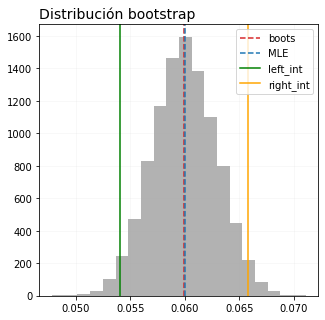

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

#Contenido de figura
ax.hist(x=boots_dist, bins=20, color='grey', alpha=0.6)
ax.axvline(x=results['boots_mean'], ymin=0, ymax=1, color='tab:red', linestyle='--', label='boots')
ax.axvline(x=results['mle_param'], ymin=0, ymax=1, color='tab:blue', linestyle='--', label='MLE')
ax.axvline(x=results['left_lim'], ymin=0, ymax=1, color='green', label='left_int')
ax.axvline(x=results['right_lim'], ymin=0, ymax=1, color='orange', label='right_int')


#Anotaciones y estilo
ax.set_title("Distribución bootstrap", fontsize=14, loc='left')
ax.grid(alpha=0.1)
ax.legend()

plt.show()

# Boostrap no paramétrico

## Simulaciones bootstrap

**Tomamos** la muestra original de datos y remuestreamos los datos $k$ veces.

In [11]:
bootsNP_dist = np.arange(0, k)
bootsNP_dist = np.vstack((bootsNP_dist, np.zeros(shape=(k,)) )).T

bootsNP_dist

array([[0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00],
       [2.000e+00, 0.000e+00],
       ...,
       [9.997e+03, 0.000e+00],
       [9.998e+03, 0.000e+00],
       [9.999e+03, 0.000e+00]])

**Después** se genera una función para hacer remuestreos bootstrap

In [12]:
def boots_NoParam(x): return np.random.choice(a=X, size=n, replace=True).mean()

**Finalmente** se aplica la función a columna de ceros en `bootsNP_dist`

In [13]:
bootsNP_dist[:,1] = np.vectorize(boots_NoParam)(bootsNP_dist[:,1])
bootsNP_dist[:5]

array([[0.        , 4.84701067],
       [1.        , 4.95759731],
       [2.        , 4.95029966],
       [3.        , 4.97617843],
       [4.        , 4.88501076]])

## Reportando resultados

In [14]:
results_NP = {'mle_param': [theta_bar],
           'boots_param': [bootsNP_dist[:,1].mean()],
           'std_err': [bootsNP_dist[:,1].std()],
           'left_lim': [bootsNP_dist[:,1].mean() - 2*bootsNP_dist[:,1].std()],
           'right_lim': [bootsNP_dist[:,1].mean() + 2*bootsNP_dist[:,1].std()]}

pd.DataFrame(results_NP)

,mle_param,boots_param,std_err,left_lim,right_lim
0,4.863642,4.863422,0.103229,4.656964,5.06988


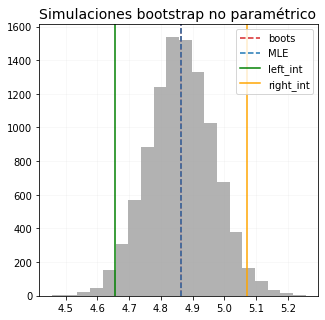

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

#Contenido de figura
ax.hist(x=bootsNP_dist[:,1], bins=20, color='grey', alpha=0.6)
ax.axvline(x=results_NP['boots_param'], ymin=0, ymax=1, color='tab:red', linestyle='--', label='boots')
ax.axvline(x=results_NP['mle_param'], ymin=0, ymax=1, color='tab:blue', linestyle='--', label='MLE')
ax.axvline(x=results_NP['left_lim'], ymin=0, ymax=1, color='green', label='left_int')
ax.axvline(x=results_NP['right_lim'], ymin=0, ymax=1, color='orange', label='right_int')


#Anotaciones y estilo
ax.set_title("Simulaciones bootstrap no paramétrico", fontsize=14, loc='left')
ax.grid(alpha=0.1)
ax.legend()

plt.show()

# Observaciones

* En ambos casos, el estimador Bootstrap fue muy cercano al estimador MLE y plug-in respectivamente.
* En el caso de Boostrap No Paramétrico, el límite izquierdo es más alto mientras que el derecho es más bajo, comparado con Bootstrap Paramétrico. Esto hace que el rango del intervalo de confianza sea más pequeño
* En contraste, el sesgo del estimador en Bootstrap Paramétrico es menor que en No Paramétrico.
* Sin embargo, a pesar del punto anterior, el error estándar de No Paramétrico es menor.
---